## Introducción<pre>
Este notebook combina todas las pruebas realizadas en la carpeta `misc` para llevar a cabo una reconstrucción tridimensional a partir de imágenes bidimensionales. El objetivo es capturar fotografías y obtener el objeto en formato 3D (.dae) siguiendo los pasos de calibrado, determinación de la posición de la cámara, extracción de siluetas e implementación de la técnica de Visual Hull. A lo largo de este notebook, integraremos estos componentes para realizar la reconstrucción completa y generar un modelo tridimensional del objeto.
</pre>.to.


## Instalación de Librerías e Importación de Dependencias

En esta sección, instalaremos las librerías necesarias y realizaremos la importación de todas las dependencias requeridas para la ejecución del algoritmo de reconstrucción 3D. Nos aseguraremos de que todas las herramientas estén disponibles para llevar a cabo cada uno de los pasos del proceso.



In [2]:
#!pip install matplotlib
#!pip install numpy
#!pip install glob
#!pip install pandas
#!pip install scipy

In [3]:
import matplotlib.pyplot as plt
import glob
import numpy as np 
import cv2
cv = cv2
from cv2 import aruco
import pandas as pd
import matplotlib as mpl
from scipy.spatial.transform import Rotation

## Visualización de Imágenes

En esta sección, mostramos todas las imágenes que se utilizarán para la reconstrucción 3D. Estas imágenes han sido capturadas desde diferentes ángulos para proporcionar la información necesaria para los pasos posteriores de calibrado, determinación de la posición de la cámara, extracción de siluetas e implementación de la técnica de Visual Hull.

A continuación, se cargan y visualizan todas las imágenes utilizando `matplotlib`.


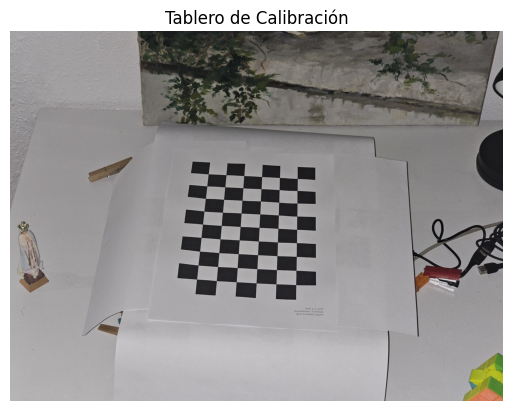

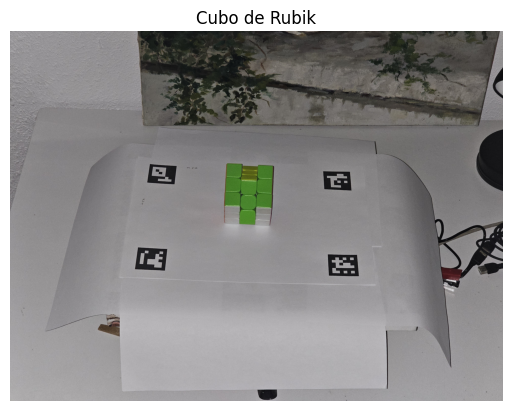

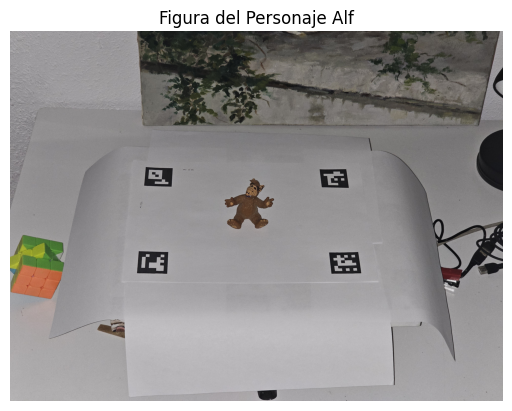

In [5]:
# Especificar las rutas de las imágenes para cada carpeta
images_paths_cube = glob.glob('img/v2/pid-cube/*.jpg')
images_paths_chess = glob.glob('img/v2/pid-chess/*.jpg')
images_paths_alf = glob.glob('img/v2/pid-alf/*.jpg')

# Mostrar una imagen de la carpeta 'img/v2/pid-chess'
plt.figure()
img_chess = plt.imread(images_paths_chess[0])  # Leer la primera imagen de la lista
img_chess = np.flipud(img_chess)               # Voltear la imagen en la dirección arriba/abajo
plt.imshow(img_chess)                          # Mostrar la imagen
plt.title('Tablero de Calibración')            # Título de la imagen
plt.axis('off')                                # Eliminar los ejes
plt.show()    

# Mostrar una imagen de la carpeta 'img/v2/pid-cube'
plt.figure()
img_cube = plt.imread(images_paths_cube[0])  # Leer la primera imagen de la lista
img_cube = np.flipud(img_cube)               # Voltear la imagen en la dirección arriba/abajo
plt.imshow(img_cube)                         # Mostrar la imagen
plt.title('Cubo de Rubik')                   # Título de la imagen
plt.axis('off')                              # Eliminar los ejes
plt.show()                                   # Mostrar la imagen

                                 # Mostrar la imagen

# Mostrar una imagen de la carpeta 'img/v2/pid-alf'
plt.figure()
img_alf = plt.imread(images_paths_alf[0])  # Leer la primera imagen de la lista
img_alf = np.flipud(img_alf)               # Voltear la imagen en la dirección arriba/abajo
plt.imshow(img_alf)                        # Mostrar la imagen
plt.title('Figura del Personaje Alf')      # Título de la imagen
plt.axis('off')                            # Eliminar los ejes
plt.show()                                 # Mostrar la imagen


## Funciones de Calibrado

En esta sección, se introducen las funciones necesarias para el calibrado de cámaras. Utilizaremos dos métodos diferentes para realizar la calibración: uno utilizando marcadores ArUco y otro utilizando un tablero de ajedrez. Estas funciones permitirán obtener los parámetros de calibración necesarios para corregir las distorsiones y mejorar la precisión en la reconstrucción 3D. Posteriormente, usaremos el método que proporcione los mejores resultados.


### Calibrado con Marcadores ArUco

Esta función realiza la calibración de la cámara utilizando marcadores ArUco. Los marcadores ArUco son patrones cuadrados con códigos binarios que pueden ser detectados robustamente en las imágenes. La función `calibrate_from_template` se encarga de leer las imágenes desde una plantilla especificada, detectar los marcadores ArUco, y calcular los parámetros de calibración de la cámara. Además, permite visualizar los marcadores detectados sobre las imágenes. Al final del proceso, se obtienen los parámetros necesarios para corregir las distorsiones de la cámara y mejorar la precisión en la reconstrucción 3D.


In [50]:
def calibrate_from_template(template, show_images=False):

        objpoints = []
        imgpoints = []
        for plantilla in glob.glob(template):
            try:
                # Lectura de la imagen
                frame = cv2.imread(plantilla)
                
                # Aplicación de ArUco
                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
                parameters =  aruco.DetectorParameters()
                detector = aruco.ArucoDetector(aruco_dict, parameters)
                corners, ids, rejectedImgPoints = detector.detectMarkers(gray)
                if show_images:
                    frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)
                    for i in range(len(ids)):
                        c = corners[i][0]
                        plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
                    plt.imshow(frame_markers)
                    plt.axis("off")
                    plt.show()
            
                # Lectura de ArUco
                def quad_area(data):
                    l = data.shape[0]//2
                    corners = data[["c1", "c2", "c3", "c4"]].values.reshape(l, 2,4)
                    c1 = corners[:, :, 0]
                    c2 = corners[:, :, 1]
                    c3 = corners[:, :, 2]
                    c4 = corners[:, :, 3]
                    e1 = c2-c1
                    e2 = c3-c2
                    e3 = c4-c3
                    e4 = c1-c4
                    a = -.5 * (np.cross(-e1, e2, axis = 1) + np.cross(-e3, e4, axis = 1))
                    return a
                corners2 = np.array([c[0] for c in corners])
                data = pd.DataFrame({"x": corners2[:,:,0].flatten(), "y": corners2[:,:,1].flatten()},
                                   index = pd.MultiIndex.from_product( 
                                           [ids.flatten(), ["c{0}".format(i )for i in np.arange(4)+1]], 
                                       names = ["marker", ""] ))
        
        
                data = data.unstack().swaplevel(0, 1, axis = 1).stack()
                data["m1"] = data[["c1", "c2"]].mean(axis = 1)
                data["m2"] = data[["c2", "c3"]].mean(axis = 1)
                data["m3"] = data[["c3", "c4"]].mean(axis = 1)
                data["m4"] = data[["c4", "c1"]].mean(axis = 1)
                data["o"] = data[["m1", "m2", "m3", "m4"]].mean(axis = 1)
        
                # Obtención de esquinas
                aruco1 = list(data.loc[(1, "c1")].values)
                aruco4 = list(data.loc[(4, "c2")].values)
                aruco12 = list(data.loc[(12, "c3")].values)
                aruco9 = list(data.loc[(9, "c4")].values)
        
                # Puntos en la imagen
                img = np.array([
                                        aruco1,     aruco4,
                                        aruco9,     aruco12     
                                    ], dtype=np.float32)
                imgpoints.append(img)
                
                # Puntos reales
                obj = np.array([
                                            (0., 0.202, 0.),     (0.270, 0.202, 0.),     
                                            (0., 0., 0.),       (0.270, 0., 0.)    
                                        ], dtype=np.float32)
                objpoints.append(obj)
            except:
                continue
            
        # Transformación de los arrays
        objpoints = np.array([objpoints], dtype=np.float32)
        objpoints = np.squeeze(objpoints)
        imgpoints = np.array([imgpoints], dtype=np.float32)
        imgpoints = np.squeeze(imgpoints)
    
        # Calibrado
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        # Retorno de parámetros de la cámara
        print("calibration done")
        return ret, mtx, dist, rvecs, tvecs


### Calibrado con Tablero de Ajedrez

Esta función realiza la calibración de la cámara utilizando un tablero de ajedrez. El método se basa en la detección de las esquinas del tablero en las imágenes capturadas. La función `scanner_calibrate_camera` lee las imágenes de una ruta especificada, encuentra las esquinas del tablero de ajedrez, y calcula los parámetros de calibración de la cámara. Si se desea, se pueden visualizar las esquinas detectadas en las imágenes. Al final del proceso, se obtienen los parámetros de la cámara necesarios para corregir las distorsiones y mejorar la precisión en la reconstrucción 3D.


In [6]:

def scanner_calibrate_camera(path='img/calibrate/showcase/angular.png', show_images=False):
    #---------------------------------PARÁMETROS
    rows_count = 6
    columns_count = 9
    #---------------------------------
    # Criterios de terminación
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.1)
    # Preparar puntos del objeto, como (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((rows_count*columns_count, 3), np.float32)
    objp[:, :2] = np.mgrid[0:columns_count, 0:rows_count].T.reshape(-1, 2)
    # Arrays para almacenar puntos del objeto y puntos de la imagen de todas las imágenes.
    objpoints = [] # Puntos 3D en el espacio del mundo real
    imgpoints = [] # Puntos 2D en el plano de la imagen
    images = glob.glob(path)
    print("Cargando imágenes: ", images)
    for fname in images:
        print("Cargando imagen: " + fname)
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Encontrar las esquinas del tablero de ajedrez
        ret, corners = cv.findChessboardCorners(gray, (columns_count, rows_count), None)
        # Si se encuentran, añadir puntos del objeto, puntos de la imagen (después de refinarlos)
        if ret == True:
            print(fname + ": calibración exitosa")
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)
            # Dibujar y mostrar las esquinas
            cv.drawChessboardCorners(img, (columns_count, rows_count), corners2, ret)
            if show_images:
                plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
                plt.axis("off")
                plt.show()
        else:
            print(fname + ": tablero de ajedrez no encontrado")

    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs


### Ejemplo de Uso

En la siguiente imagen se muestra el resultado del calibrado con el tablero de ajedrez. Las líneas de colores destacan las cuadrículas detectadas, demostrando la precisión en la detección de las esquinas del tablero. Esta visualización es crucial para validar que el proceso de calibrado se ha realizado correctamente.


Cargando imágenes:  ['img/calibrate/showcase/angular.png']
Cargando imagen: img/calibrate/showcase/angular.png
img/calibrate/showcase/angular.png: calibración exitosa


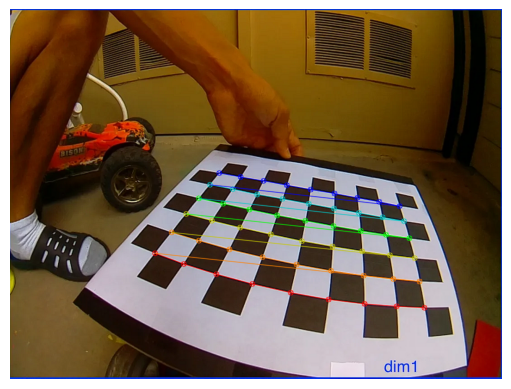

In [7]:
ret, mtx, dist, rvecs, tvecs = scanner_calibrate_camera(show_images=True)

### Estimación de la Posición de la Cámara

Esta función permite estimar la posición de la cámara utilizando marcadores ArUco. El método comienza leyendo la imagen y aplicando el detector ArUco para identificar los marcadores presentes. Luego, extrae las esquinas de los marcadores y calcula las coordenadas correspondientes en el espacio  (Estas medidas se han obtenido de la plantilla impresa en papel, midiendo las distancias entre los ArUco3D. Utilizando estos puntos y los parámetros de calibración de la cámara, la función `get_camera_position` estima la posición y orientación de la cámara en el espacio. También se puede visualizar el resultado mostrando las posiciones estimadas de los marcadores en la imagen. Esta información es esencial para la correcta reconstrucción tridimensional del objeto o escena.


In [37]:

def get_camera_position(image, mtx, dist,show_images=False):
    # 1. Lectura de la imagen
    photo = cv2.imread(image)
    
    # 2. Aplicación de ArUco
    gray = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
    aruco_dict = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    parameters =  aruco.DetectorParameters()
    detector = aruco.ArucoDetector(aruco_dict, parameters)
    corners, ids, rejectedImgPoints = detector.detectMarkers(gray)

    # 3. Lectura de ArUco
    if len(corners) < 4 :
        print("not all arucos detected")
        return [],[],[]
        
    corners2 = np.array([c[0] for c in corners])
    data = pd.DataFrame({"x": corners2[:,:,0].flatten(), "y": corners2[:,:,1].flatten()},
                       index = pd.MultiIndex.from_product( 
                               [ids.flatten(), ["c{0}".format(i )for i in np.arange(4)+1]], 
                           names = ["marker", ""] ))


    data = data.unstack().swaplevel(0, 1, axis = 1).stack()
    data["m1"] = data[["c1", "c2"]].mean(axis = 1)
    data["m2"] = data[["c2", "c3"]].mean(axis = 1)
    data["m3"] = data[["c3", "c4"]].mean(axis = 1)
    data["m4"] = data[["c4", "c1"]].mean(axis = 1)
    data["o"] = data[["m1", "m2", "m3", "m4"]].mean(axis = 1)
    
    # 4. Obtención de esquinas
    aruco1 = list(data.loc[(1, "c1")].values)
    aruco4 = list(data.loc[(4, "c2")].values)
    aruco9 = list(data.loc[(9, "c4")].values)
    aruco12 = list(data.loc[(12, "c3")].values)
    
    # 5. Estimación de la posición
    im = photo
    size = im.shape

    imageWidth = size[1]
    imageHeight = size[0]
    imageSize = [imageWidth, imageHeight]

    points_2D = np.array([
                                (aruco1),     (aruco4),
                                (aruco9),     (aruco12)     
                            ])

    width= 0.262
    height = 0.281

    points_3D = np.array([
                                (-width/2, -height/2., 0),  (width/2, -height/2., 0) ,
                                (-width/2, height/2., 0), (width/2, height/2., 0)
                            ])

    success, rvecs, tvecs = cv2.solvePnP(points_3D, points_2D, mtx, dist)

    np_rodrigues = np.asarray(rvecs[:,:],np.float64)
    rmat = cv2.Rodrigues(np_rodrigues)[0]
    camera_position = -np.matrix(rmat).T @ np.matrix(tvecs)
    #Test the solvePnP by projecting the 3D Points to camera
    projPoints = cv2.projectPoints(points_3D, rvecs, tvecs, mtx, dist)[0]
    
    if show_images:
        plt.axis("off")
        # Colores para cada ArUco marker
        colors_2D = [(155, 0, 0), (0, 155, 0), (0, 0, 155), (155, 155, 0)]  # Red, Green, Blue, Yellow for 2D points
        colors_3D = [(255, 150, 150), (150, 255, 150), (150, 150, 255), (255, 255, 150)]   # Cyan, Magenta, Orange, Spring green for 3D points
    
        # Detected in original 2D image
        for p, color in zip(points_2D, colors_2D):
            im = cv2.circle(im, (int(p[0]), int(p[1])), 30, color, -1)
    
        # Estimation in 3D and projected in 2D again
        for p, color in zip(projPoints, colors_3D):
            im = cv2.circle(im, (int(p[0][0]), int(p[0][1])), 30, color, -1)

        plt.imshow(im)
        plt.show()
    
    # Matriz de rotación
    rotation_matrix, _ = cv2.Rodrigues(rvecs)

    # Invertir la transformación para obtener la posición de la cámara en las coordenadas del mundo
    rotation_matrix_inv = rotation_matrix.T
    camera_position = -rotation_matrix_inv @ tvecs
    return camera_position, rotation_matrix, [aruco1, aruco4, aruco9, aruco12]


# Experimentación

A continuación se muestan el uso de las dos funciones, se comparan los resultados para usar la que mejor aproxima los puntos. En oscuro se ven los puntos de los ArUco detectados y en un color más claro los puntos 3D calculados con la calibración vueltos a proyectar en la imagen. Lo ideal seria que estén lo más proximo posible.

Cargando imágenes:  ['img/v2/pid-chess\\20240509_235220.jpg', 'img/v2/pid-chess\\20240509_235230.jpg', 'img/v2/pid-chess\\20240509_235237.jpg', 'img/v2/pid-chess\\20240509_235247.jpg', 'img/v2/pid-chess\\20240509_235255.jpg', 'img/v2/pid-chess\\20240509_235303.jpg', 'img/v2/pid-chess\\20240509_235311.jpg', 'img/v2/pid-chess\\20240509_235319.jpg', 'img/v2/pid-chess\\20240509_235328.jpg', 'img/v2/pid-chess\\20240509_235335.jpg']
Cargando imagen: img/v2/pid-chess\20240509_235220.jpg
img/v2/pid-chess\20240509_235220.jpg: calibración exitosa
Cargando imagen: img/v2/pid-chess\20240509_235230.jpg
img/v2/pid-chess\20240509_235230.jpg: calibración exitosa
Cargando imagen: img/v2/pid-chess\20240509_235237.jpg
img/v2/pid-chess\20240509_235237.jpg: calibración exitosa
Cargando imagen: img/v2/pid-chess\20240509_235247.jpg
img/v2/pid-chess\20240509_235247.jpg: calibración exitosa
Cargando imagen: img/v2/pid-chess\20240509_235255.jpg
img/v2/pid-chess\20240509_235255.jpg: calibración exitosa
Cargando 

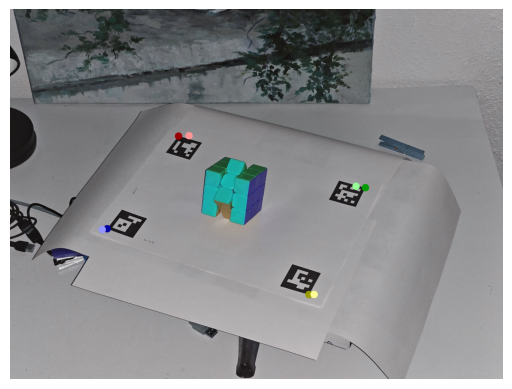

Posición: [[ 0.13800173]
 [ 0.79299881]
 [-0.56335887]]
Rotación: [[ 0.94221334 -0.27229745 -0.19516178]
 [ 0.31105889  0.49474347  0.81146242]
 [-0.12440413 -0.82527753  0.55085444]]


In [12]:
calibration_images = "img/v2/pid-chess/*.jpg"
ret, mtx, dist, rvecs, tvecs = scanner_calibrate_camera(calibration_images,False)

image_name = "img/v2/pid-cube/20240509_235711.jpg"
position, rotation, arucos = get_camera_position(image_name, mtx, dist, show_images=True)

print("Posición:", position)
print("Rotación:", rotation)


calibration done


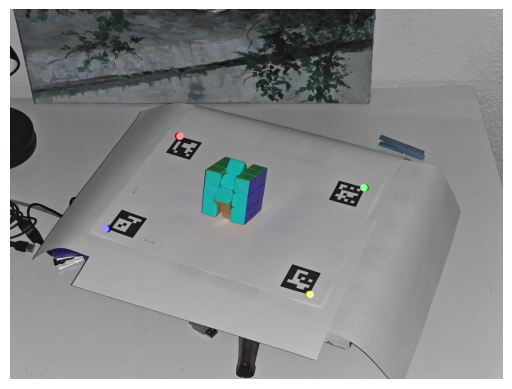

Posición: [[ 0.14185442]
 [ 3.45161435]
 [-2.67908987]]
Rotación: [[ 0.9195871  -0.2501555  -0.30295508]
 [ 0.3924832   0.54999582  0.73719844]
 [-0.01779022 -0.79682296  0.60395089]]


In [17]:
ret, mtx, dist, rvecs, tvecs = calibrate_from_template("img/v2/pid-cube/*.jpg",False)
image_name = "img/v2/pid-cube/20240509_235711.jpg"
position, rotation, arucos = get_camera_position(image_name, mtx, dist, show_images=True)

print("Posición:", position)
print("Rotación:", rotation)

### Comparación de Resultados de Calibración

En esta sección, se presentan dos imágenes lado a lado que muestran los resultados del calibrado utilizando marcadores ArUco y un tablero de ajedrez, respectivamente.


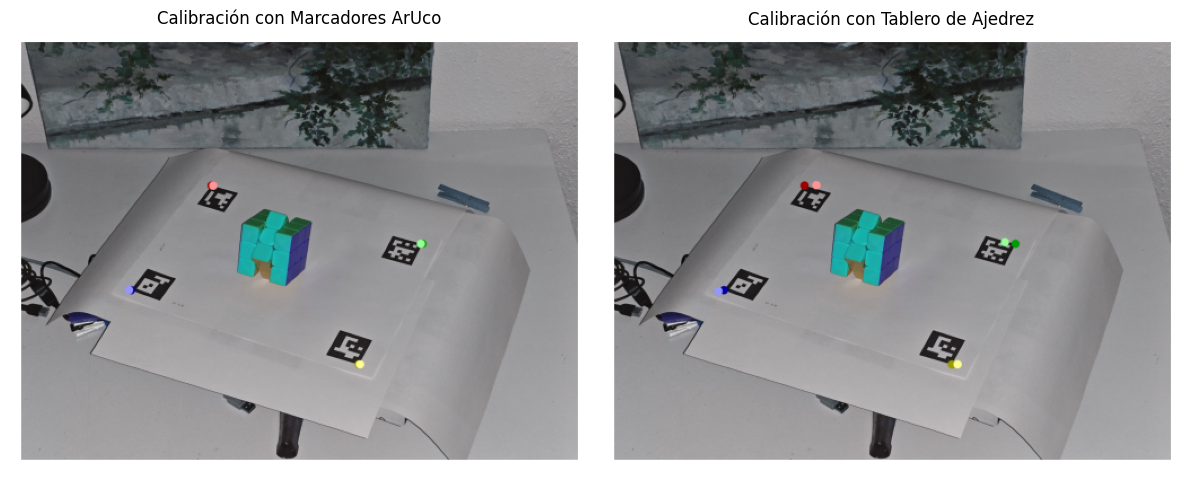

In [26]:


# Cargar las imágenes
aruco_image = cv2.imread('img/experiments/aruco-calibration.png')
chess_image = cv2.imread('img/experiments/chess-calibration.png')

# Convertir las imágenes de BGR a RGB
aruco_image_rgb = cv2.cvtColor(aruco_image, cv2.COLOR_BGR2RGB)
chess_image_rgb = cv2.cvtColor(chess_image, cv2.COLOR_BGR2RGB)

# Crear un subplot con dos imágenes lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Mostrar la imagen de calibración con ArUco
axes[0].imshow(aruco_image_rgb)
axes[0].set_title('Calibración con Marcadores ArUco')
axes[0].axis('off')

# Mostrar la imagen de calibración con tablero de ajedrez
axes[1].imshow(chess_image_rgb)
axes[1].set_title('Calibración con Tablero de Ajedrez')
axes[1].axis('off')

# Mostrar las imágenes
plt.tight_layout()
plt.show()


Como se puede obvservar la calibración de los ArUco es mejor que la del tablero de ajedrez, probablemente por que tiene un numero mayor de imágenes y la lente empleada apenas tiene distorsión, por lo que no hacen falta mas de 4 puntos conocidos.

## Comprobación de la Posición de la Cámara en el Espacio 3D
En esta sección, se procesan un conjunto de imágenes de la carpeta `img/v2/pid-alf`  para determinar y visualizar las posiciones de una cámara en el espacio tridimensional. Utilizando funciones previamente definidas, se extraen las coordenadas x, y y z de cada imagen y se almacenan en listas. Luego, se genera una gráfica 3D con Plotly, donde cada punto representa la posición de la cámara, permitiendo una visualización clara y detallada de su ubicación en el espacio.

In [28]:
!pip install plotly
import plotly.graph_objects as go
import plotly

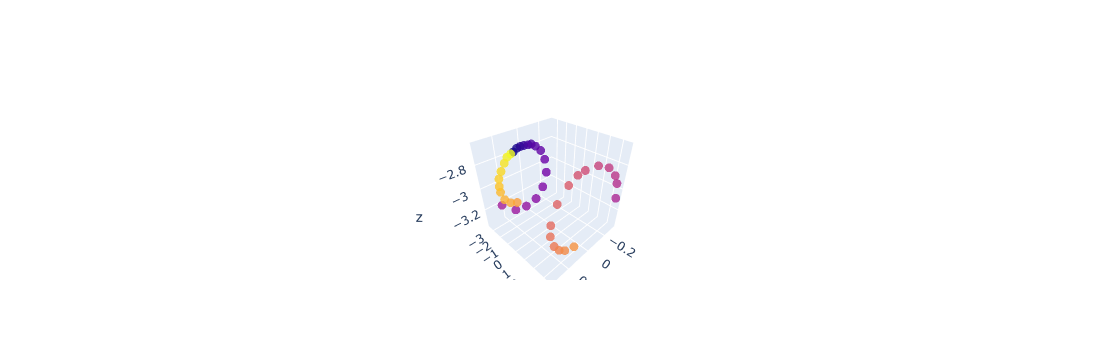

In [29]:

# Obtener todos los nombres de archivos de imágenes en la carpeta especificada
image_names = glob.glob("img/v2/pid-alf/*.jpg")

# Asumiendo que las funciones get_camera_position, mtx, y dist ya están definidas

# Preparar listas para almacenar las coordenadas x, y, z de las posiciones de la cámara
positions = []
x_coords = []
y_coords = []
z_coords = []

# Iterar sobre cada nombre de imagen
i = 0
colors = []
for image_name in image_names:
    i += 1
    if i > 200: 
        continue
    # Obtener la posición y rotación de la cámara
    position, rotation, _ = get_camera_position(image_name, mtx, dist, show_images=False)
    positions.append(position)
    # Almacenar las coordenadas x, y, z
    x_coords.append(position[0][0])
    y_coords.append(position[1][0])
    z_coords.append(position[2][0])
    colors.append(i)

# Configurar el trace
trace = go.Scatter3d(
    x=x_coords,
    y=y_coords,
    z=z_coords,
    mode='markers',
    marker={
        'size': 5,
        'opacity': 0.8,
        'color': colors,
    }
)

# Crear la figura con el trace
data = [trace]
plot_figure = go.Figure(data=data)

# Renderizar el gráfico
plotly.offline.iplot(plot_figure)

## Comparativa de Posiciones de Cámara
Se muestra la comparativa de las posiciones de cámara esperadas (sacadas de los metadatos ofrecidos de las imágenes de la librería de dinosaurios de la implementación del apartado 4) en la carpeta `MISC` comparada con los resultados que nos han dado usando los resultados ArUco.



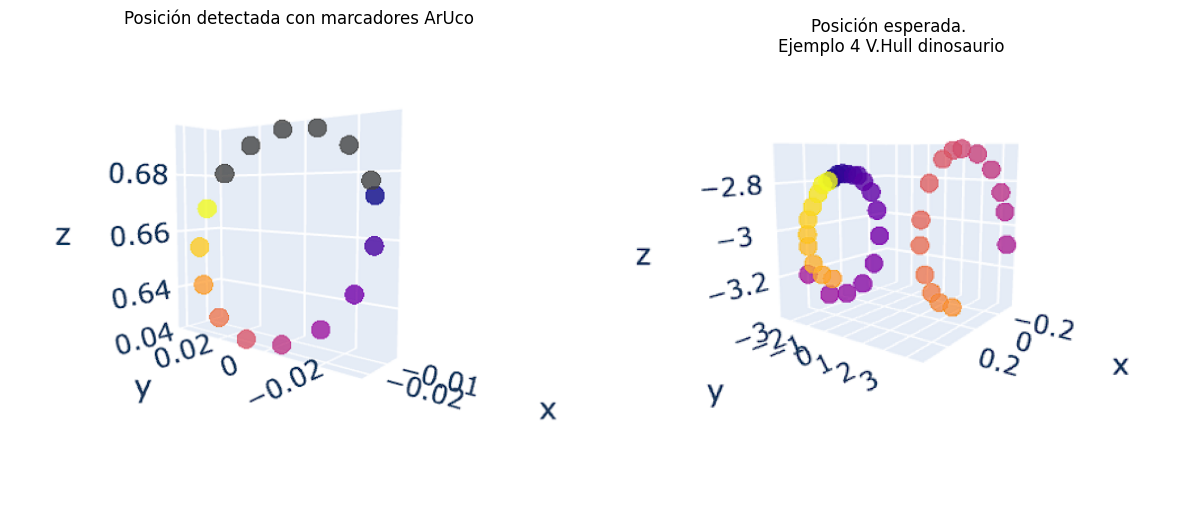

In [33]:
# Cargar las imágenes
aruco_image = cv2.imread('img/experiments/camera-position-dino.png')
chess_image = cv2.imread('img/experiments/camera-position.png')

# Convertir las imágenes de BGR a RGB
aruco_image_rgb = cv2.cvtColor(aruco_image, cv2.COLOR_BGR2RGB)
chess_image_rgb = cv2.cvtColor(chess_image, cv2.COLOR_BGR2RGB)

# Crear un subplot con dos imágenes lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Mostrar la imagen de calibración con ArUco
axes[0].imshow(aruco_image_rgb)
axes[1].set_title('Posición esperada. \nEjemplo 4 V.Hull dinosaurio')
axes[0].axis('off')

# Mostrar la imagen de calibración con tablero de ajedrez
axes[0].set_title('Posición detectada con marcadores ArUco')
axes[1].imshow(chess_image_rgb)
axes[1].axis('off')

# Mostrar las imágenes
plt.tight_layout()
plt.show()


Como se puede ver, la figura izquierda es un círculo (esperado), pero la figura derecha, que también se tomó rodeando el objeto, tiene otra forma, lo que indica que la función de posición tiene algún error.


Por esto, la implementación del visual hull se hará con las imágenes de los dinosaurios y no con las nuestras. Sin embargo, usaremos nuestra implementación de la detección de siluetas, que se explica a continuación.

# Siluetas

## Recorte de la Imagen
Para evitar extraer siluetas de otros objetos fuera del cuadrado formado por los ArUcos, es necesario recortar la imagen adecuadamente. A continuación se presenta el código necesario para realizar este recorte y una explicación detallada de cada paso.

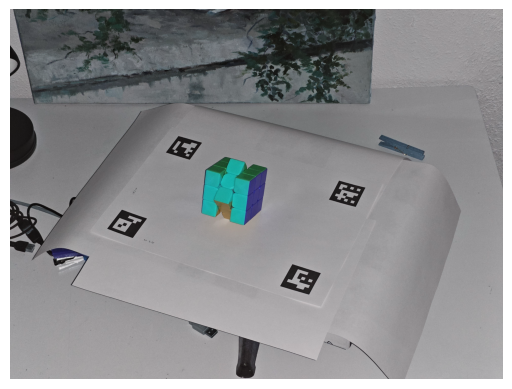

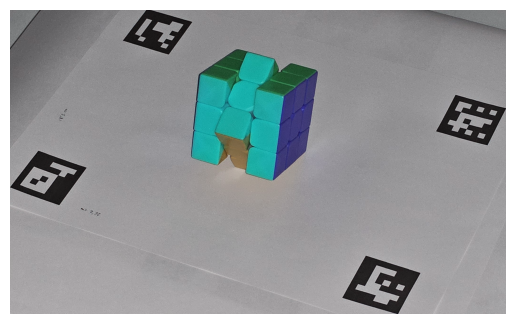

Borders(top=1030, bottom=685, left=788, right=1117)


In [44]:
from collections import namedtuple


def trim_image_by_points(image, points_in_image, margin=[0,0,0,0]):
    # Define un tipo de tupla nombrada para los bordes
    Borders = namedtuple('Borders', ['top', 'bottom', 'left', 'right'])
    
    # Convierte los puntos a un array de numpy si no lo son ya
    points = np.array(points_in_image)

    # Calcula las coordenadas mínimas y máximas en x e y
    min_x = np.min(points[:, 0])
    max_x = np.max(points[:, 0])
    min_y = np.min(points[:, 1])
    max_y = np.max(points[:, 1])

    # Calcula los bordes
    top_border = int(min_y - margin[0])
    bottom_border = int(image.shape[0] - max_y - margin[1])
    left_border = int(min_x - margin[2])
    right_border = int(image.shape[1] - max_x - margin[3])

    # Recorta la imagen usando las coordenadas calculadas
    trimmed_image = image[top_border:int(image.shape[0] - bottom_border),
                          left_border:int(image.shape[1] - right_border)]

    # Crea una tupla nombrada para los bordes
    borders = Borders(top=top_border, bottom=bottom_border, left=left_border, right=right_border)

    return trimmed_image, borders

# Ejemplo de uso:

# Nombre de la imagen
image_name = "img/v2/pid-cube/20240509_235711.jpg"

# Lee la imagen
image = cv2.imread(image_name)

# Obtén la posición de la cámara (función de ejemplo anterior)
position, rotation, arucos = get_camera_position(image_name, mtx, dist, show_images=False)

# Muestra la imagen original
plt.imshow(image)
plt.axis('off')
plt.show()

# Recorta la imagen usando los puntos de ArUco
result_image, borders = trim_image_by_points(image, arucos, [0,0,0,0])

# Muestra la imagen recortada
plt.imshow(result_image)
plt.axis('off')
plt.show()

# Imprime los bordes calculados
print(borders)



## Algoritmo de Obtención de Siluetas
El algoritmo de obtención de siluetas realiza varios pasos para procesar la imagen y extraer la silueta del objeto principal. A continuación se detallan estos pasos y su propósito:

1. Carga de la Imagen: Se carga la imagen a procesar. Si la imagen no puede ser cargada, se retorna un mensaje de error.

2. Conversión a Escala de Grises: La imagen se convierte a escala de grises para simplificar el procesamiento, ya que las operaciones de detección de bordes y contornos funcionan mejor en imágenes en blanco y negro.

3. Reducción de Ruido: Se aplica un filtro Gaussiano para suavizar la imagen y reducir el ruido. Esto ayuda a mejorar la detección de bordes en el siguiente paso.

4. Detección de Bordes: Se utiliza el algoritmo de Canny para detectar los bordes en la imagen. Este paso resalta los contornos del objeto.

5. Engrosamiento de Bordes: Los bordes detectados se engrosan mediante una operación de dilatación, seguida de una erosión para refinar los bordes. Esto asegura que los bordes sean lo suficientemente gruesos para formar contornos cerrados.

6. Reducción Adicional de Ruido: Se aplica un filtro mediano para eliminar el ruido restante sin perder los detalles de los bordes.

7. Umbralización: Se aplica un umbral para convertir la imagen suavizada en una imagen binaria, manteniendo solo los valores de gris superiores a un cierto umbral.

8. Encontrar Contornos: Se buscan los contornos en la imagen umbralizada. Estos contornos representan las fronteras de los objetos en la imagen.

9. Dibujar y Rellenar Contornos: Se crea una máscara en blanco y negro donde los contornos detectados se dibujan y rellenan.

10. Encontrar el Contorno Más Grande: Entre todos los contornos detectados, se identifica el contorno más grande, que se asume corresponde a la silueta del objeto principal.

Este proceso asegura que la silueta del objeto principal en la imagen se extraiga de manera precisa, minimizando la interferencia de otros elementos presentes en la imagen original.

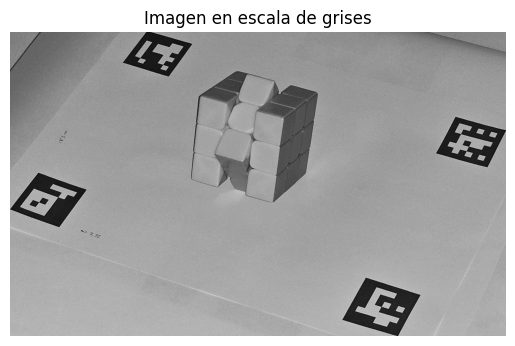

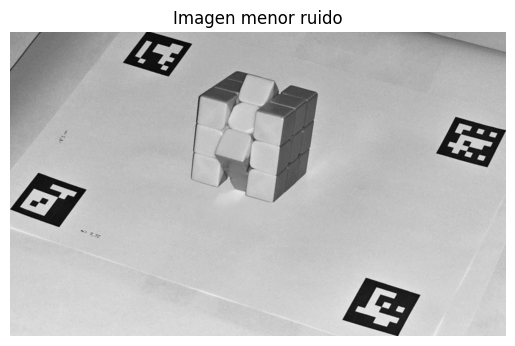

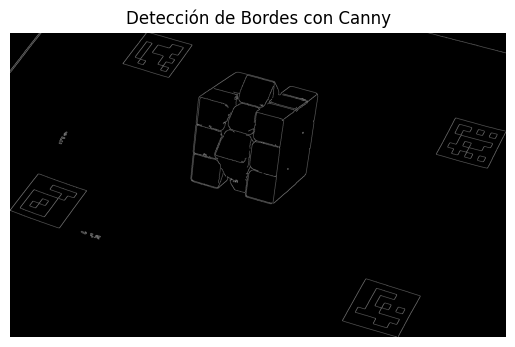

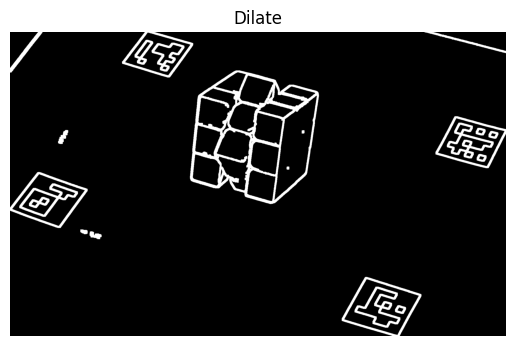

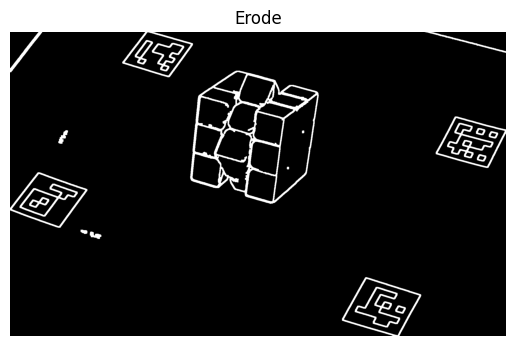

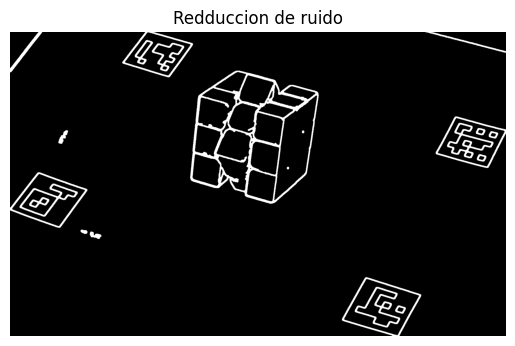

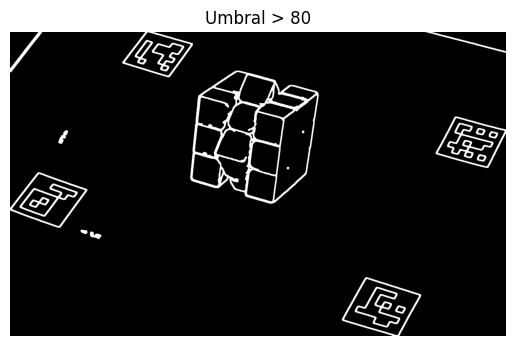

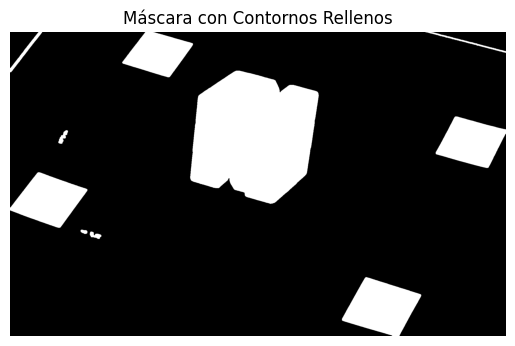

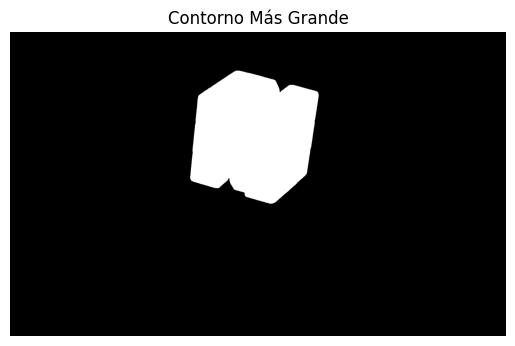

In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def process_image(image,showImages=False):
    # Cargar la imagen

    if image is None:
        return "No se pudo cargar la imagen"
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if showImages:
        plt.imshow(gray, cmap='gray')
        plt.title('Imagen en escala de grises')
        plt.axis('off')
        plt.show()
    # Reduccion de ruido
    gray = cv2.GaussianBlur(gray, (7,7), 0)
    if showImages:
        plt.imshow(gray, cmap='gray')
        plt.title('Imagen menor ruido')
        plt.axis('off')
        plt.show()

    # Detección de bordes con Canny
    t_lower = 5  # Lower Threshold 
    t_upper = 120  # Upper threshold 
    edges = cv2.Canny(gray, t_lower, t_upper)
    if showImages:
        plt.imshow(edges, cmap='gray')
        plt.title('Detección de Bordes con Canny')
        plt.axis('off')
        plt.show()


    # Engrosar los bordes detectados
        # Crear un kernel
    kernel = np.ones((8,8), np.uint8)
    
    # Aplicar la operación de apertura
    dilated_image = cv2.morphologyEx(edges, cv2.MORPH_DILATE, kernel)
    if showImages:
        plt.imshow(dilated_image, cmap='gray')
        plt.title('Dilate')
        plt.axis('off')
        plt.show()
    kernel = np.ones((3,3), np.uint8)
    erode_image = cv2.morphologyEx(dilated_image, cv2.MORPH_ERODE, kernel)
    if showImages:
        plt.imshow(erode_image, cmap='gray')
        plt.title('Erode')
        plt.axis('off')
        plt.show()
    
    # Aplicar filtro  para eliminar el ruido
    blurred_image = cv2.medianBlur(erode_image, 5)
    if showImages:
        plt.imshow(blurred_image, cmap='gray')
        plt.title('Redduccion de ruido')
        plt.axis('off')
        plt.show()

        # Aplicar umbral para mantener solo los valores de gris > thresh
    thesh=80
    _, thresholded_image = cv2.threshold(blurred_image, thesh, 255, cv2.THRESH_BINARY)
    
    # Mostrar la imagen umbralizada
    if showImages:
        plt.imshow(thresholded_image, cmap='gray')
        plt.title('Umbral > '+str(thesh))
        plt.axis('off')
        plt.show()

    # Encontrar contornos
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Dibujar y rellenar contornos
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)
    if showImages:

        plt.imshow(mask, cmap='gray')
        plt.title('Máscara con Contornos Rellenos')
        plt.axis('off')
        plt.show()

    # Encontrar el contorno más grande basado en el área
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Crear una imagen para mostrar el contorno más grande
    largest_contour_image = np.zeros_like(gray)
    cv2.drawContours(largest_contour_image, [largest_contour], -1, (255), thickness=cv2.FILLED)
    
    # Mostrar el contorno más grande
    if showImages:
        plt.imshow(largest_contour_image, cmap='gray')
        plt.title('Contorno Más Grande')
        plt.axis('off')
        plt.show()

    return largest_contour_image
    

# Llamada a la función
silhouette = process_image(result_image,showImages=True)


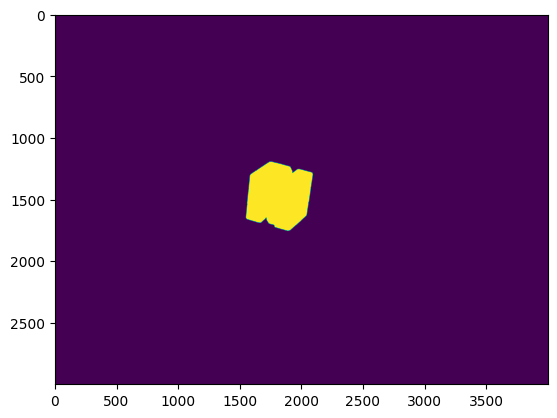

In [48]:
new_image = cv2.copyMakeBorder(silhouette, borders.top, borders.bottom, borders.left, borders.right, 
                                   cv2.BORDER_CONSTANT, value=[0, 0, 0])
plt.imshow(new_image)
plt.show()

# Algoritmo principal de preparacion de imagenes

Recorre las imagenes genera las siluetas y detecta los parametros de la camara para pasarselos al visual hull

calibration done
img/v2/pid-alf\20240509_235911.jpg


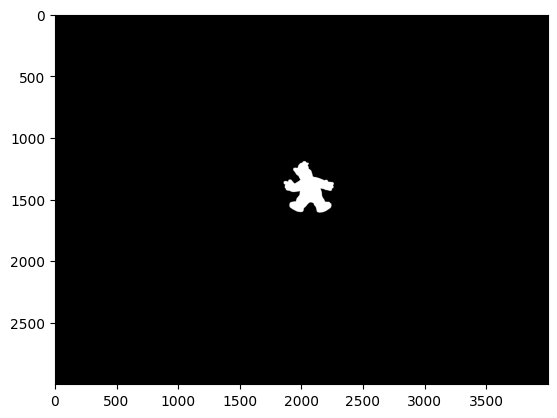

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.99973834  0.02059142  0.00996189]
 [ 0.00364937 -0.28634569  0.95811942]
 [ 0.02258158  0.95790508  0.28619562]] t [[-0.02426188]
 [-1.52070976]
 [-0.49594341]]
img/v2/pid-alf\20240509_235922.jpg


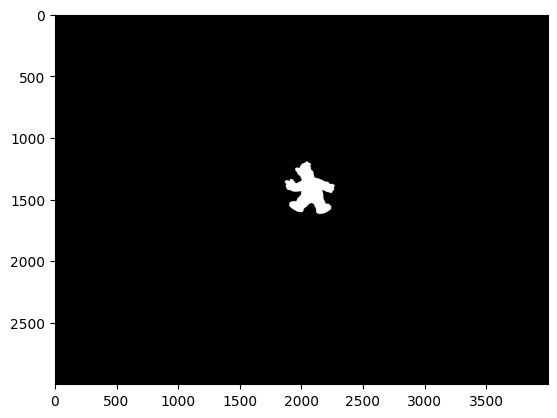

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.99661414  0.08062967 -0.01609688]
 [-0.0385994  -0.28595563  0.95746512]
 [ 0.07259711  0.95484461  0.28809968]] t [[-0.1010466 ]
 [-1.51963138]
 [-0.50026103]]
img/v2/pid-alf\20240509_235932.jpg


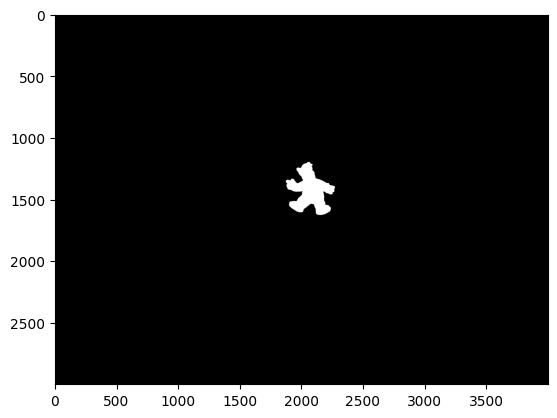

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.99176703  0.1236384  -0.03334234]
 [-0.06769234 -0.28516127  0.95608619]
 [ 0.10870102  0.95047178  0.29118291]] t [[-0.15738153]
 [-1.52010022]
 [-0.50766579]]
img/v2/pid-alf\20240509_235940.jpg


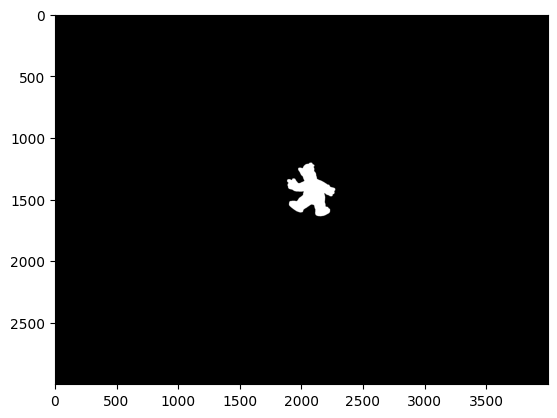

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.98225785  0.17890336 -0.05624141]
 [-0.10623282 -0.28366599  0.95302056]
 [ 0.15454481  0.94208662  0.29763855]] t [[-0.23009998]
 [-1.51990716]
 [-0.52239317]]
img/v2/pid-alf\20240509_235947.jpg


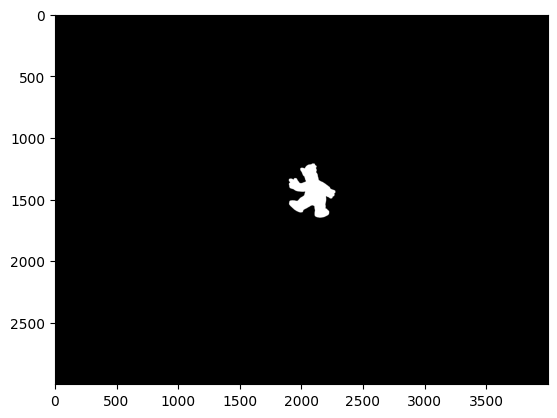

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.96614068  0.24463136 -0.08202249]
 [-0.15143118 -0.28023254  0.94791261]
 [ 0.20890378  0.9282377   0.30778887]] t [[-0.31914323]
 [-1.51873737]
 [-0.54601981]]
img/v2/pid-alf\20240510_000001.jpg


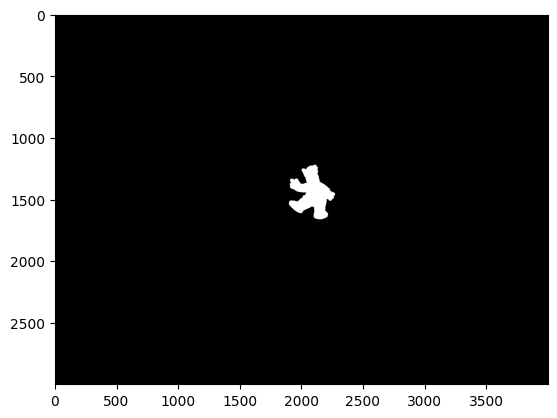

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.94936703  0.29695871 -0.10255616]
 [-0.18805635 -0.27564943  0.94268351]
 [ 0.25166853  0.91423898  0.31753745]] t [[-0.39194701]
 [-1.51566869]
 [-0.56960931]]
img/v2/pid-alf\20240510_000009.jpg


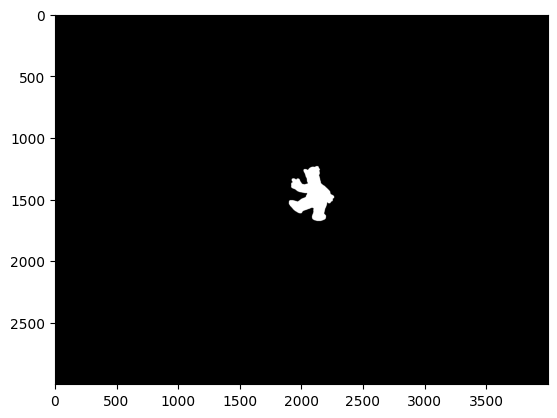

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.91841405  0.37377081 -0.12965732]
 [-0.24097344 -0.26859151  0.93262554]
 [ 0.31376335  0.88778037  0.33674705]] t [[-0.50404408]
 [-1.50871231]
 [-0.61608923]]
img/v2/pid-alf\20240510_000016.jpg


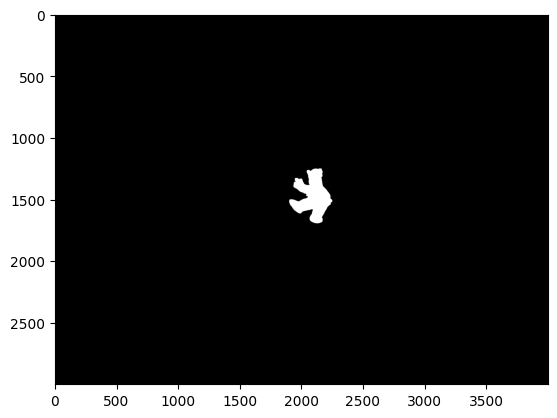

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.85311846  0.49424969 -0.16705131]
 [-0.32444127 -0.25184792  0.9117623 ]
 [ 0.4085667   0.83203959  0.37521111]] t [[-0.69182773]
 [-1.48286456]
 [-0.71312016]]
img/v2/pid-alf\20240510_000024.jpg


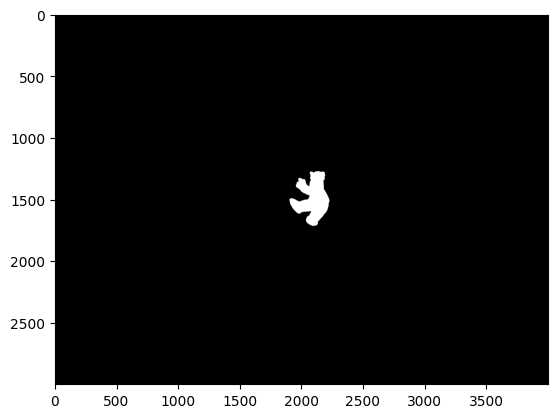

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.74006696  0.64270416 -0.19807133]
 [-0.42750966 -0.22221927  0.87627284]
 [ 0.51916894  0.73317798  0.43921938]] t [[-0.94626605]
 [-1.40157328]
 [-0.88438878]]
img/v2/pid-alf\20240510_000032.jpg


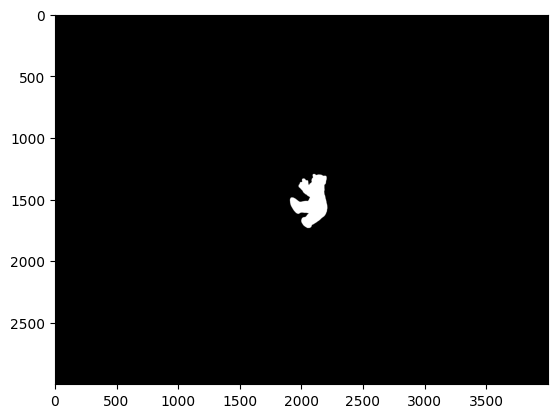

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.5574522   0.8063822  -0.197471  ]
 [-0.54082615 -0.17225762  0.82330698]
 [ 0.62988421  0.56575177  0.53213797]] t [[-1.25829301]
 [-1.18442843]
 [-1.1570085 ]]
img/v2/pid-alf\20240510_000040.jpg


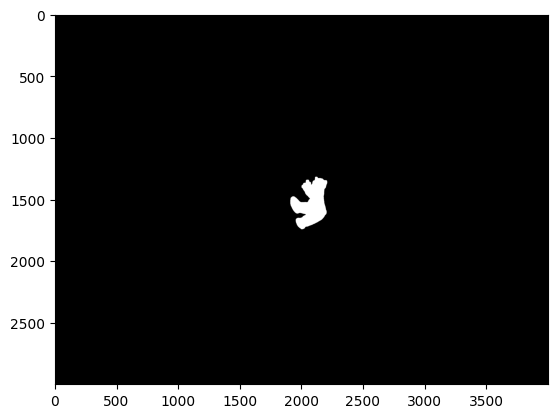

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.28447872  0.95106271 -0.12062996]
 [-0.64428013 -0.09648638  0.75867878]
 [ 0.70991195  0.29354746  0.64019912]] t [[-1.54832235]
 [-0.67720278]
 [-1.50336642]]
img/v2/pid-alf\20240510_000047.jpg


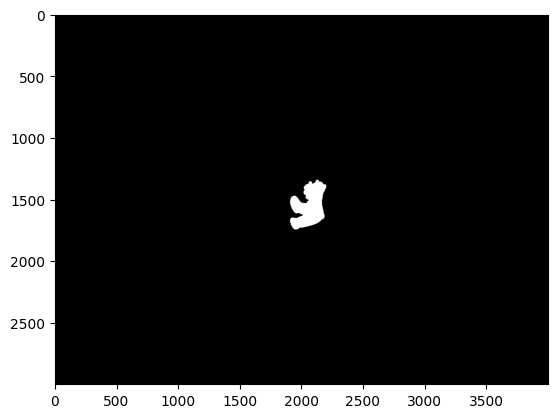

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.02615358  0.99902581  0.0355446 ]
 [-0.68339523 -0.00808234  0.73000386]
 [ 0.72957998 -0.04338322  0.68251809]] t [[-1.64165987]
 [ 0.08604118]
 [-1.64915732]]
img/v2/pid-alf\20240510_000054.jpg


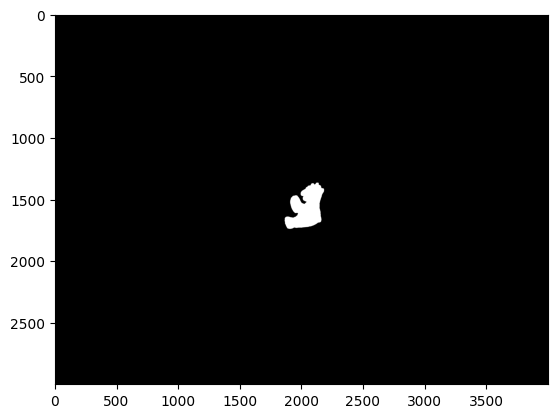

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.31768394  0.93170021  0.17610121]
 [-0.64395873  0.07567676  0.7613082 ]
 [ 0.69598424 -0.3552573   0.62401778]] t [[-1.50198036]
 [ 0.77881532]
 [-1.45345208]]
img/v2/pid-alf\20240510_000101.jpg


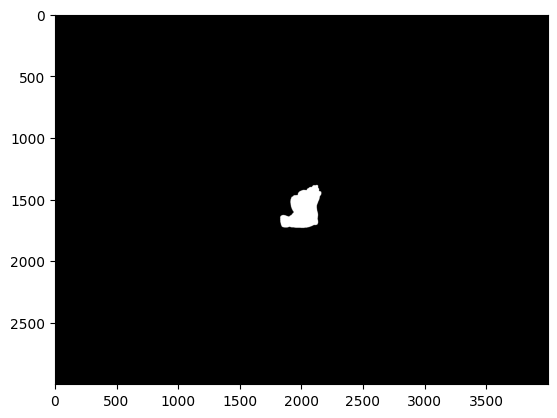

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.52514161  0.81853813  0.23285534]
 [-0.57041394  0.13549904  0.81010367]
 [ 0.63154907 -0.55824308  0.53806174]] t [[-1.27286519]
 [ 1.15112776]
 [-1.18194999]]
img/v2/pid-alf\20240510_000108.jpg


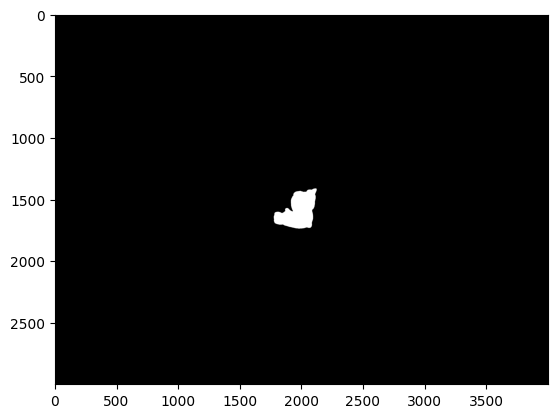

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.75144728  0.61743717  0.23259046]
 [-0.43735131  0.20218219  0.87626833]
 [ 0.49401499 -0.7601932   0.42196622]] t [[-0.88819704]
 [ 1.40862596]
 [-0.84509623]]
img/v2/pid-alf\20240510_000115.jpg


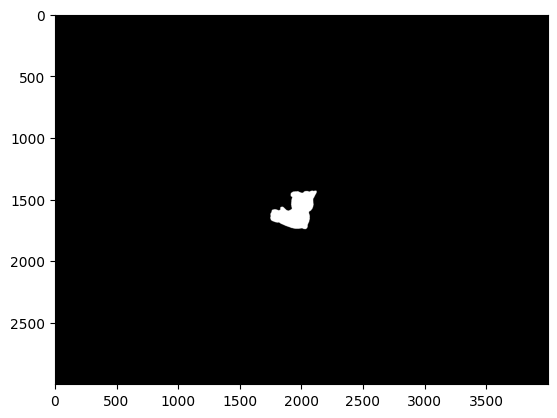

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.84702238  0.49090719  0.20387058]
 [-0.3517531   0.23009673  0.90737272]
 [ 0.39852584 -0.84027711  0.36757521]] t [[-0.67096628]
 [ 1.46712042]
 [-0.70130488]]
img/v2/pid-alf\20240510_000123.jpg


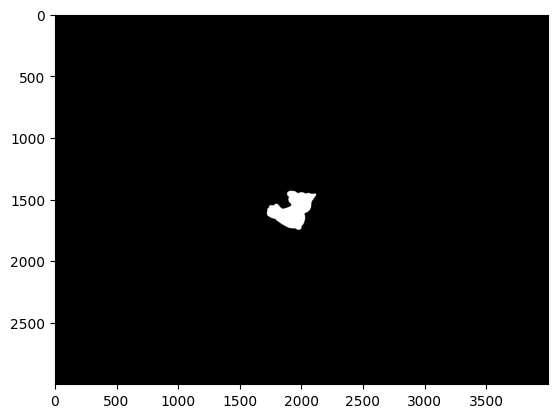

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.93580696  0.32033916  0.14713314]
 [-0.23562465  0.25797146  0.93698012]
 [ 0.26219527 -0.91150071  0.31689128]] t [[-0.40744557]
 [ 1.49119499]
 [-0.57455219]]
img/v2/pid-alf\20240510_000132.jpg


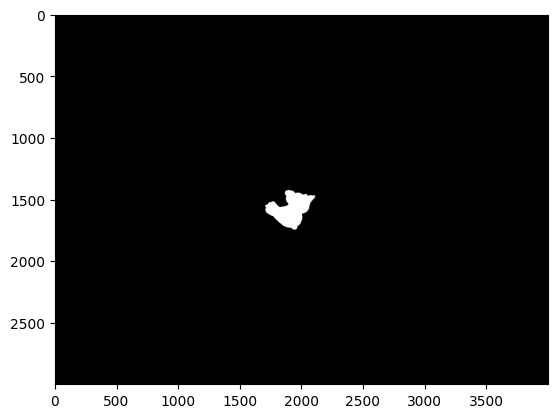

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.97113369  0.21370646  0.10596656]
 [-0.16291756  0.26975009  0.94904834]
 [ 0.17423328 -0.93891663  0.29677994]] t [[-0.25722993]
 [ 1.4935498 ]
 [-0.52683405]]
img/v2/pid-alf\20240510_000140.jpg


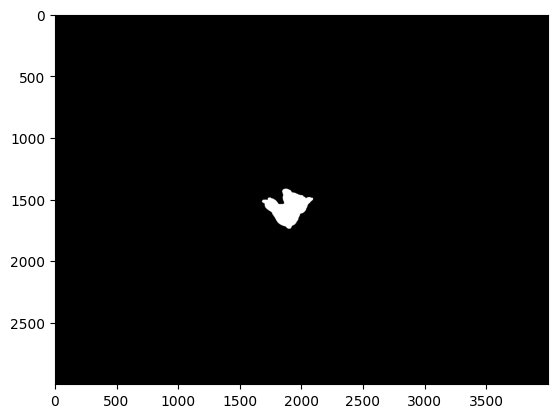

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.99658703  0.06814006  0.04659639]
 [-0.06391446  0.27970336  0.95795666]
 [ 0.05224206 -0.95766537  0.28310388]] t [[-0.06328467]
 [ 1.49039739]
 [-0.49445602]]
img/v2/pid-alf\20240510_000152.jpg


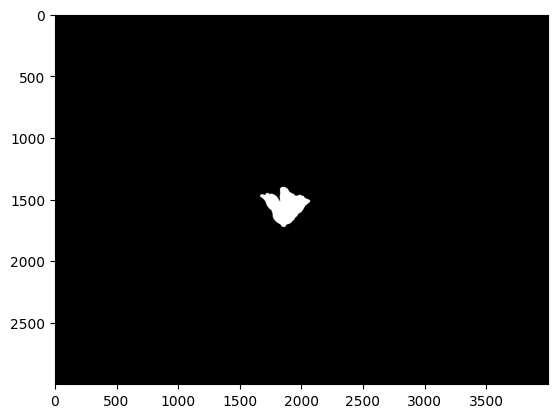

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.99654061 -0.08151048 -0.01621303]
 [ 0.03868518  0.28230018  0.95854581]
 [-0.07355459 -0.95585702  0.28447684]] t [[ 0.13134892]
 [ 1.49089376]
 [-0.49825   ]]
img/v2/pid-alf\20240510_000200.jpg


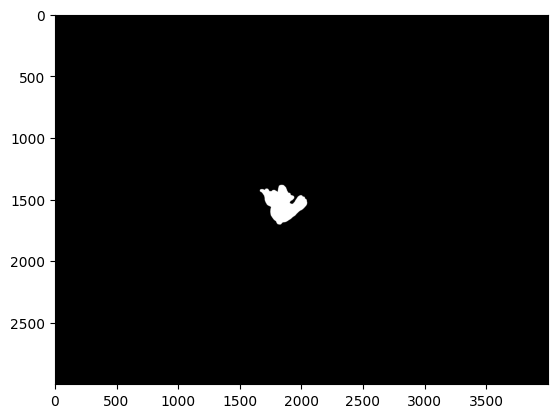

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.97089301 -0.2268145  -0.07695415]
 [ 0.14033422  0.27833035  0.95017815]
 [-0.19409551 -0.93332063  0.30205882]] t [[ 0.32519144]
 [ 1.49133859]
 [-0.53923096]]
img/v2/pid-alf\20240510_000208.jpg


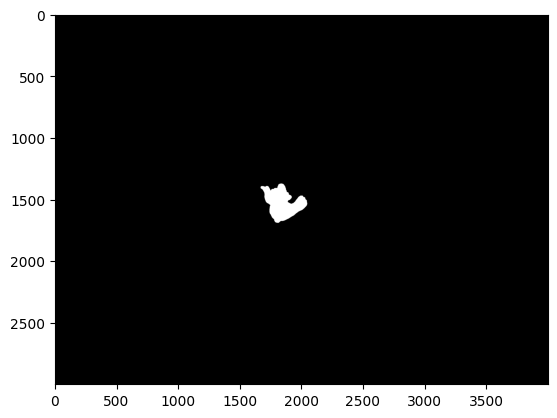

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.94368469 -0.31151543 -0.11143314]
 [ 0.20106745  0.27252694  0.94090432]
 [-0.26273768 -0.91032258  0.31981512]] t [[ 0.44432096]
 [ 1.49112477]
 [-0.58229346]]
img/v2/pid-alf\20240510_000216.jpg


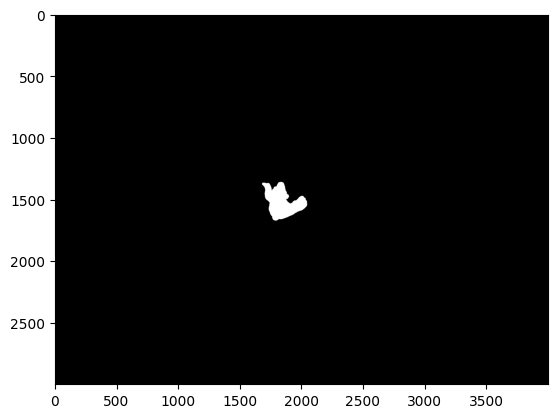

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.89841882 -0.4134128  -0.14809955]
 [ 0.27337118  0.26258047  0.92537544]
 [-0.343674   -0.87186086  0.34892238]] t [[ 0.59808689]
 [ 1.4853913 ]
 [-0.65577436]]
img/v2/pid-alf\20240510_000224.jpg


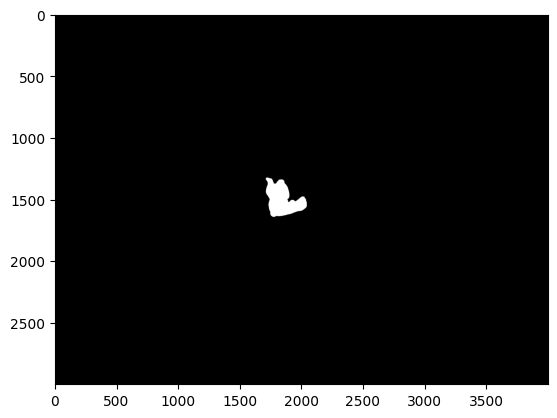

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.79098329 -0.58048436 -0.1933477 ]
 [ 0.3913842   0.23715455  0.88914348]
 [-0.4702806  -0.77897087  0.4147777 ]] t [[ 0.87569246]
 [ 1.43307324]
 [-0.83063137]]
img/v2/pid-alf\20240510_000232.jpg


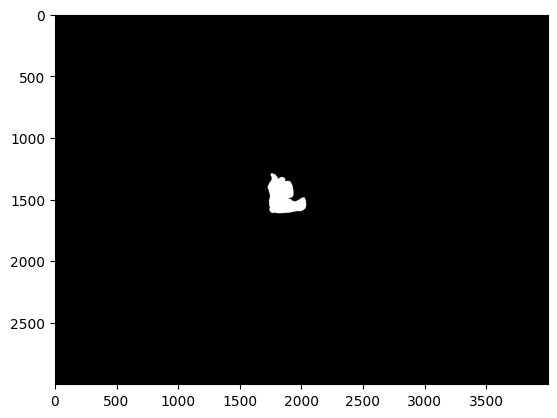

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.63105454 -0.74770689 -0.20665086]
 [ 0.50712913  0.19605152  0.83927579]
 [-0.58701807 -0.63442746  0.50290315]] t [[ 1.18841646]
 [ 1.27314457]
 [-1.08657663]]
img/v2/pid-alf\20240510_000239.jpg


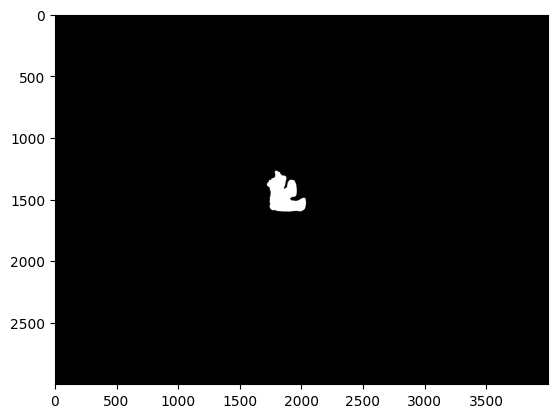

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.48050071 -0.85739404 -0.18437605]
 [ 0.5829545   0.15519321  0.79754569]
 [-0.65519701 -0.49070411  0.57439216]] t [[ 1.40416891]
 [ 1.04104252]
 [-1.3068571 ]]
img/v2/pid-alf\20240510_000246.jpg


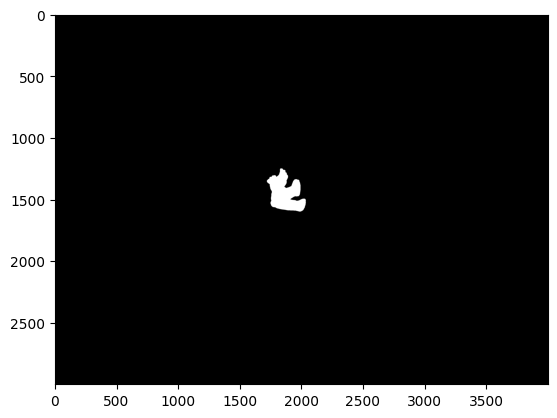

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.26839025 -0.95691985 -0.1107749 ]
 [ 0.65216708  0.09586353  0.75198955]
 [-0.70897446 -0.2740704   0.64980046]] t [[ 1.60467462]
 [ 0.60535429]
 [-1.554779  ]]
img/v2/pid-alf\20240510_000254.jpg


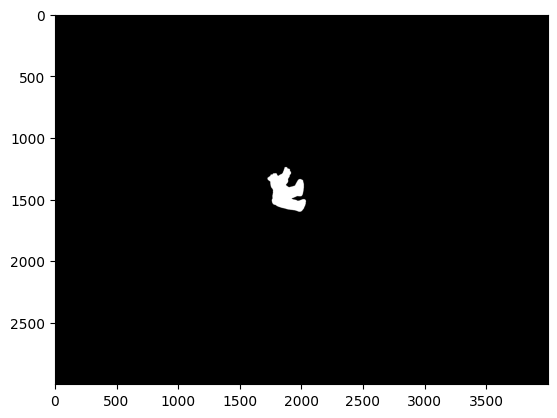

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[ 0.07182646 -0.99732561 -0.01351234]
 [ 0.6810729   0.03914394  0.73116855]
 [-0.7286842  -0.06172014  0.68206302]] t [[ 1.68174065]
 [ 0.12005929]
 [-1.66177236]]
img/v2/pid-alf\20240510_000302.jpg


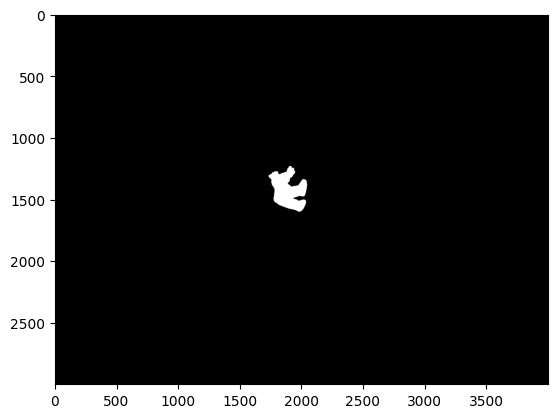

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.10597501 -0.99114292  0.08003126]
 [ 0.67863346 -0.01326413  0.73435733]
 [-0.72679153  0.13213541  0.67402841]] t [[ 1.66410981]
 [-0.33202686]
 [-1.63002322]]
img/v2/pid-alf\20240510_000310.jpg


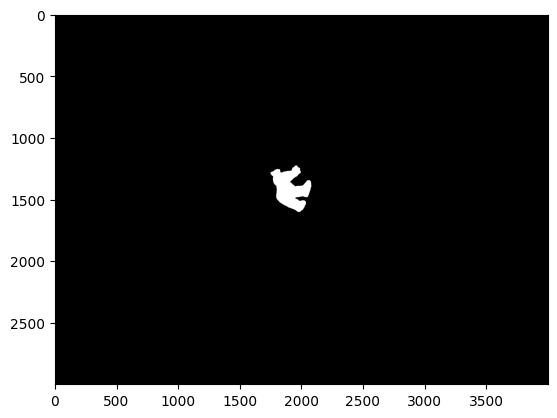

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.34070228 -0.92253549  0.1812463 ]
 [ 0.6357906  -0.08406223  0.76727039]
 [-0.6925982   0.37664547  0.61517959]] t [[ 1.51578313]
 [-0.86166167]
 [-1.42743975]]
img/v2/pid-alf\20240510_000318.jpg


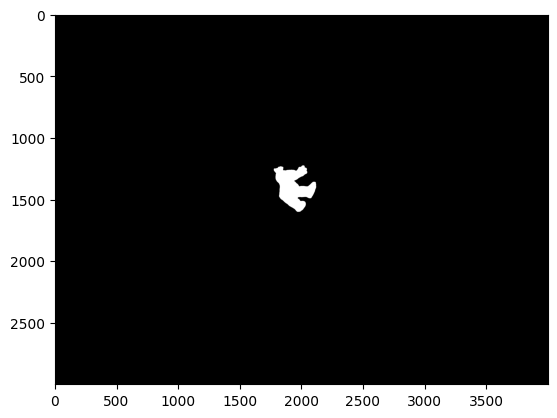

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.55933151 -0.79571585  0.23234575]
 [ 0.55458383 -0.15088262  0.81833441]
 [-0.61610473  0.58657542  0.52568455]] t [[ 1.25328511]
 [-1.2334839 ]
 [-1.14171759]]
img/v2/pid-alf\20240510_000326.jpg


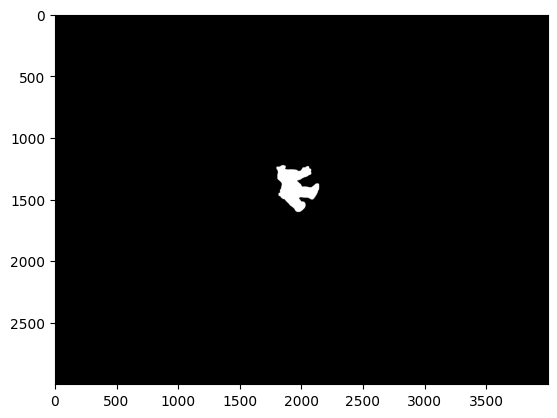

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.67482287 -0.69880765  0.2372382 ]
 [ 0.49158206 -0.18588501  0.85076074]
 [-0.55041909  0.69073485  0.46896076]] t [[ 1.06363566]
 [-1.37442018]
 [-0.9731475 ]]
img/v2/pid-alf\20240510_000333.jpg


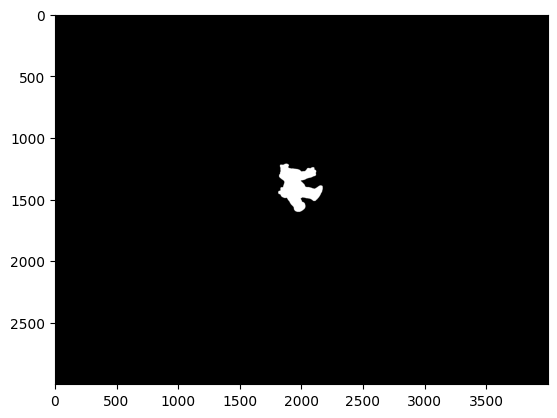

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.78185132 -0.5821043   0.22330045]
 [ 0.41488782 -0.21842649  0.88326551]
 [-0.46537792  0.78322695  0.41228502]] t [[ 0.84981592]
 [-1.46672527]
 [-0.81379042]]
img/v2/pid-alf\20240510_000341.jpg


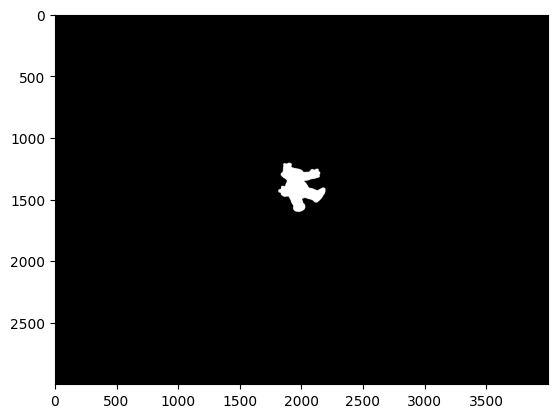

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.85461903 -0.47885218  0.20081562]
 [ 0.34714413 -0.23928513  0.90677096]
 [-0.38615706  0.84465568  0.37072834]] t [[ 0.67415816]
 [-1.50602048]
 [-0.70308902]]
img/v2/pid-alf\20240510_000348.jpg


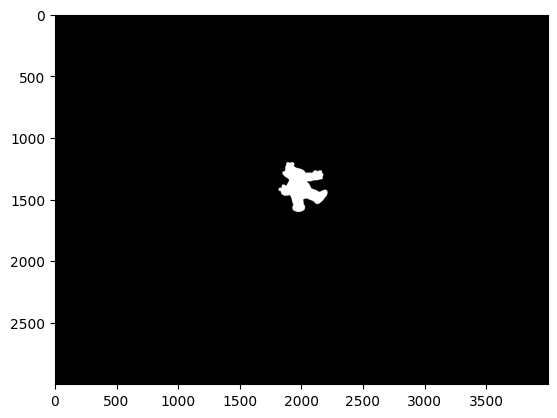

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.9035504  -0.39165847  0.17378241]
 [ 0.28796074 -0.25471262  0.92314685]
 [-0.3172937   0.88415221  0.34292795]] t [[ 0.53661596]
 [-1.52090191]
 [-0.63190954]]
img/v2/pid-alf\20240510_000356.jpg


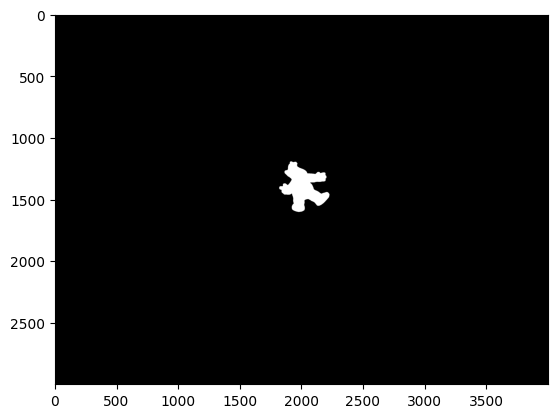

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.94260919 -0.30212138  0.14216394]
 [ 0.2266039  -0.26612478  0.9369249 ]
 [-0.24523169  0.91536893  0.31931355]] t [[ 0.40504648]
 [-1.5268467 ]
 [-0.57462042]]
img/v2/pid-alf\20240510_000403.jpg


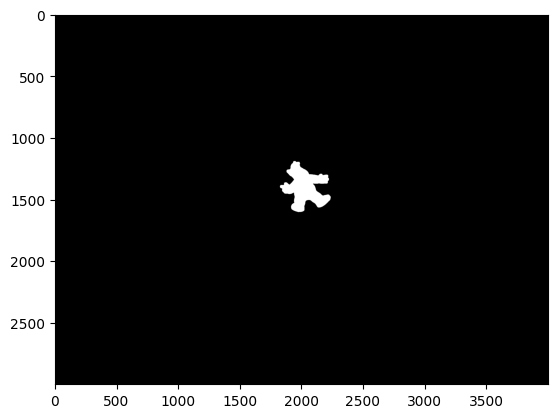

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.96927722 -0.21981069  0.1103854 ]
 [ 0.1701002  -0.27484605  0.94632213]
 [-0.17767273  0.93602506  0.30379186]] t [[ 0.28992688]
 [-1.52545288]
 [-0.53697899]]
img/v2/pid-alf\20240510_000411.jpg


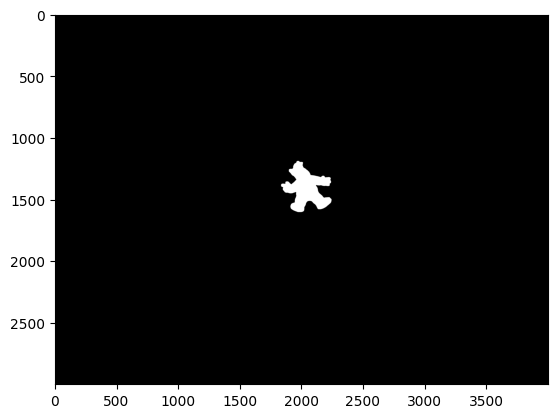

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.98760695 -0.13684616  0.07684815]
 [ 0.11303191 -0.28046482  0.95318585]
 [-0.10888663  0.95005927  0.29245699]] t [[ 0.17896664]
 [-1.52272021]
 [-0.51042995]]
img/v2/pid-alf\20240510_000418.jpg


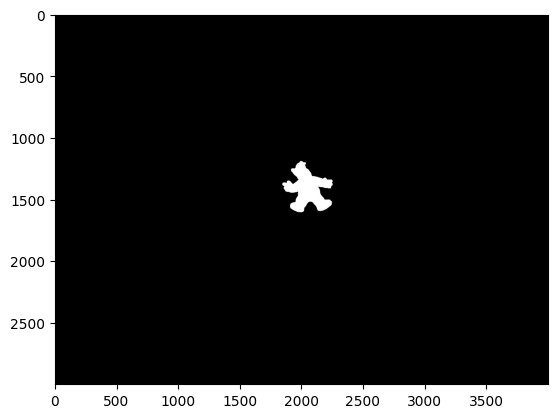

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.99709719 -0.06222988  0.04387078]
 [ 0.05983008 -0.28401472  0.95695141]
 [-0.04709102  0.95679835  0.28691349]] t [[ 0.08297777]
 [-1.51874411]
 [-0.49712482]]
img/v2/pid-alf\20240510_000424.jpg


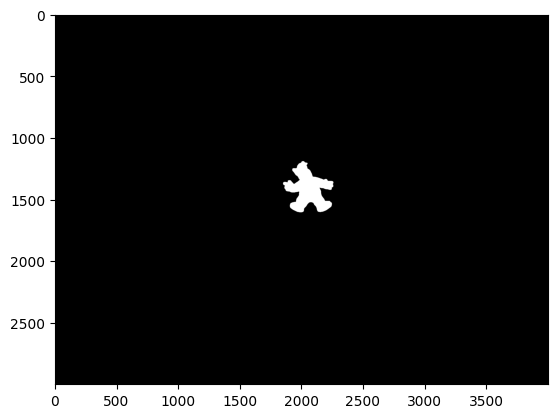

k [[1.01151162e+04 0.00000000e+00 1.99028624e+03]
 [0.00000000e+00 1.51388607e+04 1.11606118e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]] R [[-0.99945122 -0.01937296  0.02686914]
 [ 0.0312831  -0.28531184  0.95792407]
 [-0.01089174  0.95823893  0.28576132]] t [[ 0.02739469]
 [-1.52002827]
 [-0.49510279]]


In [52]:
import glob
# calibration_image_path = "img/v2/pid-chess/*.jpg" #para calibracion por tablero
calibration_image_path = "img/v2/pid-alf/*.jpg" #para calibracion por aruco
images_paths = glob.glob("img/v2/pid-alf/*.jpg")
#1 Parametros de camara
ret, mtx, dist, rvecs, tvecs = calibrate_from_template(calibration_image_path,show_images=False)
#Numero de imagenes exitosas
N=0
#Array de matrices
M=[]
#Imagenes en formato silueta
silhouettes = []
for file_name in images_paths:
    
    #1 Deteccion de arucos
    print(file_name)
    position, rotation , arucos = get_camera_position(file_name, mtx, dist)
    if len(arucos)<4 : 
        print("No se detectaron todos los marcadores, saltando imagen" )
        continue

    #2 Obtener siluetas
    image = cv.imread(file_name)
    # plt.imshow(image)
    # plt.show()
    # recorte de imagen por arucos
    result_image, borders = trim_image_by_points(image,arucos,[0,0,0,0])
    # obtencion de la silueta
    silhouette_short = process_image(result_image,showImages=False)
    silhouette_full = cv2.copyMakeBorder(silhouette_short, borders.top, borders.bottom, borders.left, borders.right, 
                                   cv2.BORDER_CONSTANT, value=[0, 0, 0])
    plt.imshow(silhouette_full,cmap="gray")
    plt.show()
    silhouettes.append(silhouette_full)
    K= mtx #parametros de la camara
    R= rotation
    t= position
    print("k",K,"R",R,"t",t)
    M.append(np.matmul(K, np.concatenate([R, t], axis=1)))
    N+=1
    
    
    
    

In [61]:
silhouettes = np.array(silhouettes).transpose(1, 2, 0)

# Visual Hull by egrigokhan
Esta implementación del algoritmo de Visual Hull es del usuario de GitHub egrigokhan. Es una adaptación de una implementación original de MATLAB. Lo único que hemos hecho ha sido modificar el código para imprimir las posiciones de la cámara, como se vio en la experimentación anterior, y también para añadirle comentarios para una mejor comprensión del proceso.m

## InitializeVoxels
La función InitializeVoxels define una cuadrícula de vóxeles en un espacio tridimensional basado en los límites y tamaños de vóxel especificados para los ejes x, y y z. Calcula el número de vóxeles necesarios en cada dirección y crea una matriz de vóxeles inicializada con unos. Utilizando los límites proporcionados, la función establece los pasos en cada dirección y crea una cuadrícula 3D de vóxeles con np.meshgrid. Luego, llena la matriz de vóxeles con las coordenadas 3D de cada vóxel, asegurando que cada vóxel esté correctamente posicionado dentro de los límites especificados. Finalmente, la función retorna la matriz de vóxeles y las cuadrículas 3D generadas, así como el número de vóxeles en cada dirección.

In [54]:
# Define una cuadrícula de vóxeles que tiene las ubicaciones 3D de cada vóxel, 
# los cuales luego pueden proyectarse en cada imagen.
def InitializeVoxels(xlim, ylim, zlim, voxel_size):
  # Número de vóxeles en cada dirección (x, y, z)
  voxels_number = [1, 1, 1]
  voxels_number[0] = np.abs(xlim[1]-xlim[0]) / voxel_size[0]  # Número de vóxeles en la dirección x
  voxels_number[1] = np.abs(ylim[1]-ylim[0]) / voxel_size[1]  # Número de vóxeles en la dirección y
  voxels_number[2] = np.abs(zlim[1]-zlim[0]) / voxel_size[2]  # Número de vóxeles en la dirección z
  
  # Convertir los números de vóxeles a enteros y sumar 1 para incluir el límite final
  voxels_number_act = np.array(voxels_number).astype(int) + 1
  
  # Número total de vóxeles
  total_number = np.prod(voxels_number_act)

  # Crear una matriz para los vóxeles, inicializada con unos
  voxel = np.ones((int(total_number), 4))

  # Definir los límites iniciales y finales para cada eje
  sx = xlim[0]
  ex = xlim[1]
  sy = ylim[0]
  ey = ylim[1]
  sz = zlim[0]
  ez = zlim[1]

  # Definir los pasos en cada dirección dependiendo de los límites
  if ex > sx:
    x_step = voxel_size[0]
  else:
    x_step = -voxel_size[0]

  if ey > sy:
    y_step = voxel_size[1]
  else:
    y_step = -voxel_size[1]

  if sz > ez:
    z_step = voxel_size[2]
  else:
    z_step = -voxel_size[2]

  # Crear una cuadrícula 3D de vóxeles utilizando meshgrid
  voxel3Dx, voxel3Dy, voxel3Dz = np.meshgrid(
    np.linspace(sx, ex, voxels_number_act[0]), 
    np.linspace(sy, ey, voxels_number_act[1]),
    np.linspace(ez, sz, voxels_number_act[2])
  )
  
  # Inicializar un contador
  l = 0
  # Llenar la matriz de vóxeles con las coordenadas 3D de cada vóxel
  for z in np.linspace(ez, sz, voxels_number_act[2]):
    for x in np.linspace(sx, ex, voxels_number_act[0]):
      for y in np.linspace(sy, ey, voxels_number_act[1]):
        voxel[l] = [x, y, z, 1]  # Asignar las coordenadas del vóxel
        l = l + 1  # Incrementar el contador

  # Retornar la matriz de vóxeles y las cuadrículas 3D, junto con el número de vóxeles en cada dirección
  return voxel, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number



La cuadrícula de vóxeles se inicializa con un tamaño de vóxel definido por voxel_size y límites de dimensión xlim, ylim y zlim basados en valores específicos. Posteriormente, se llama a la función InitializeVoxels con estos parámetros para calcular el número de vóxeles necesarios en cada dirección, crear una matriz de vóxeles con las coordenadas 3D de cada uno, y retornar tanto la matriz de vóxeles como las cuadrículas 3D generadas.

In [55]:
voxel_size = [0.001, 0.001, 0.001]  # tamaño de cada vóxel

# Los límites de las dimensiones
xlim = [-0.07, 0.02]
ylim = [-0.02, 0.07]
zlim = [-0.07, 0.02]

# Inicializa la cuadrícula de vóxeles
voxels, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number = InitializeVoxels(xlim, ylim, zlim, voxel_size)


In [56]:
print(voxels.shape)

(753571, 4)


In [57]:
print(voxels.shape)

(753571, 4)


En este fragmento de código, se proyectan los puntos 3D de los vóxeles en el plano de imagen de múltiples cámaras para acumular el valor de cada vóxel en función de las siluetas proyectadas. Se utiliza la matriz de proyección de cada cámara para transformar los puntos 3D a coordenadas 2D y se asegura que estas coordenadas estén dentro de los límites de la imagen. Finalmente, se actualiza el valor acumulado de cada vóxel basado en las siluetas y se almacenan las proyecciones de los puntos 2D.

In [68]:
object_points3D = np.copy(voxels).T  # Copiar los puntos de los vóxeles y transponer
voxels[:, 3] = 0  # Poner la cuarta variable de cada vóxel en 0

proj = []

for i in range(N):
    # PARÁMETROS DE LA CÁMARA
    M_ = M[i]  # Obtener la matriz de proyección de la cámara i

    # PROYECCIÓN AL PLANO DE LA IMAGEN
    points2D = np.matmul(M_, object_points3D)  # Multiplicar la matriz de proyección por los puntos 3D
    points2D = np.floor(points2D / points2D[2, :]).astype(np.int32)  # Normalizar y convertir a enteros
    points2D[np.where(points2D < 0)] = 0  # Verificar coordenadas de imagen negativas

    img_size = silhouettes.shape
    ind1 = np.where(points2D[1, :] >= img_size[0])  # Verificar coordenadas fuera de límites (ancho)
    points2D[:, ind1] = 0
    ind1 = np.where(points2D[0, :] >= img_size[1])  # Verificar coordenadas fuera de límites (alto)
    points2D[:, ind1] = 0

    # ACUMULAR EL VALOR DE CADA VÓXEL EN LA IMAGEN ACTUAL
    voxels[:, 3] += silhouettes[:, :, i].T[points2D.T[:, 0], points2D.T[:, 1]]  # Actualizar el valor acumulado del vóxel

    proj.append(points2D)  # Almacenar las proyecciones 2D


C:\Users\manol\AppData\Local\Temp\ipykernel_25244\974476604.py:12: RuntimeWarning:

invalid value encountered in divide

C:\Users\manol\AppData\Local\Temp\ipykernel_25244\974476604.py:12: RuntimeWarning:

invalid value encountered in cast



In [69]:
print(voxels)  # El cuarto valor es el número de vistas de imagen (de un total de N) que contienen este vóxel en la máscara del objeto.


[[-0.07  -0.02   0.02   0.   ]
 [-0.07  -0.019  0.02   0.   ]
 [-0.07  -0.018  0.02   0.   ]
 ...
 [ 0.02   0.068 -0.07   0.   ]
 [ 0.02   0.069 -0.07   0.   ]
 [ 0.02   0.07  -0.07   0.   ]]


La función ConvertVoxelList2Voxel3D convierte una lista de vóxeles en una representación tridimensional (3D) de una cuadrícula de vóxeles. Basándose en el número de vóxeles y el tamaño de cada vóxel, se establecen los límites para los ejes x, y y z. Luego, se crea una matriz 3D vacía para almacenar los valores de los vóxeles. A medida que se itera sobre cada coordenada de la cuadrícula, se asignan los valores correspondientes desde la lista de vóxeles a la matriz 3D. La función retorna la representación 3D de los vóxeles.

In [70]:
def ConvertVoxelList2Voxel3D(voxels_number, voxel_size, voxel):
    # Definir los límites para el eje x
    sx = -(voxels_number[0] / 2) * voxel_size[0]
    ex = voxels_number[0] / 2 * voxel_size[0]

    # Definir los límites para el eje y
    sy = -(voxels_number[1] / 2) * voxel_size[1]
    ey = voxels_number[1] / 2 * voxel_size[1]

    # Definir los límites para el eje z
    sz = 0
    ez = voxels_number[2] * voxel_size[2]

    # Convertir el número de vóxeles a enteros
    voxels_number = np.array(voxels_number).astype(np.int32)

    # Crear una matriz 3D vacía para los vóxeles
    voxel3D = np.zeros((voxels_number[1] + 1, voxels_number[0] + 1, voxels_number[2] + 1))

    l = 0  # Inicializar el índice de la lista de vóxeles
    z1 = 0  # Inicializar el índice para el eje z
    for z in np.arange(ez, sz, -voxel_size[2]):
        x1 = 0  # Inicializar el índice para el eje x
        for x in np.arange(sx, ex, voxel_size[0]):
            y1 = 0  # Inicializar el índice para el eje y
            for y in np.arange(sy, ey, voxel_size[1]):
                # Asignar el valor del vóxel a la matriz 3D
                voxel3D[y1, x1, z1] = voxel[l, 3]
                l = l + 1  # Incrementar el índice de la lista de vóxeles
                y1 = y1 + 1  # Incrementar el índice para el eje y
            x1 = x1 + 1  # Incrementar el índice para el eje x
        z1 = z1 + 1  # Incrementar el índice para el eje z

    return voxel3D  # Retornar la matriz 3D de los vóxeles


Este fragmento de código calcula el umbral para el algoritmo de Marching Cubes basado en la cantidad máxima de votos recibidos por los vóxeles. Se define un valor de error permitido y se calcula el valor isosuperficie, que es utilizado para la generación de la superficie 3D. Luego, se convierte la lista de vóxeles a una representación tridimensional utilizando la función ConvertVoxelList2Voxel3D.

In [71]:
# Cantidad de error permitida
error_amount = 5

# Obtener el número máximo de votos entre los vóxeles
maxv = np.max(voxels[:, 3])

# Calcular el valor isosuperficie para el algoritmo de Marching Cubes
iso_value = maxv - np.round(((maxv) / 100) * error_amount) - 0.5

# Imprimir el número máximo de votos
print('max number of votes:' + str(maxv))

# Imprimir el umbral para el algoritmo de Marching Cubes
print('threshold for marching cube:' + str(iso_value))

# Convertir la lista de vóxeles a una representación tridimensional
voxel3D = ConvertVoxelList2Voxel3D(np.array(voxels_number), voxel_size, voxels)


max number of votes:0.0
threshold for marching cube:-0.5


In [72]:
!pip install --upgrade PyMCubes
!pip install pycollada

Se utiliza el algoritmo de Marching Cubes para extraer la isosuperficie y se exporta el resultado en formato dae

In [73]:
import numpy as np
import mcubes

# Extract the 0-isosurface
vertices, triangles = mcubes.marching_cubes(voxel3D, iso_value)

# Export the result to sphere.dae
mcubes.export_mesh(vertices, triangles, "cube2.dae", "cube")

El archivo `.dae` se puede visualizar utilizando la herramienta en línea disponible en [3DViewer.net](https://3dviewer.net/). Esta web permite cargar y visualizar modelos 3D en varios formatos, incluyendo `.dae`, proporcionando una forma rápida y sencilla de inspeccionar y interactuar con tus modelos sin necesidad de instalar software adicional.